# Setup


In [1]:
import sys; sys.path.insert(0, '../')
import warnings

# ignore warnings from PyTorch Lightning about using num_workers > 0
# since we are using cpu, not gpu
warnings.filterwarnings("ignore", ".*which may be a bottleneck.*")
warnings.filterwarnings("ignore", ".*IProgress not found.*")
warnings.filterwarnings("ignore", ".*smaller than the logging interval.*")

In [2]:
from ase.io import read
import numpy as np


structures = [s for s in read('../data/bulk_amo.extxyz', index=':') if len(s) == 64]
dft_energies = np.array([atom.get_potential_energy() for atom in structures])
local_energies = np.array([atom.arrays['gap17_energy'] for atom in structures])

dft_energies.shape, local_energies.shape

((1625,), (1625, 64))

In [3]:
from quippy.descriptors import Descriptor

desc = Descriptor('soap cutoff=3.7 n_max=10 l_max=10 atom_sigma=0.5')
soaps = np.array([desc.calc(s)['data'] for s in structures])
soaps.shape

(1625, 64, 606)

In [5]:
from src.data import naïve_cv, shape_preserving_scaler
import torch

X = soaps
y = local_energies 
targets = dft_energies.reshape(-1, 1)

X, y, targets = naïve_cv(X, y, targets)

X = X.map(shape_preserving_scaler(X.train))
targets = targets - y.train.mean() * 64
y = y - y.train.mean()

# GAP17 Performance


In [6]:
from src.data import mae

# MAE for structural energies (eV)
mae(local_energies.sum(axis=1), dft_energies)

2.3823066614584802

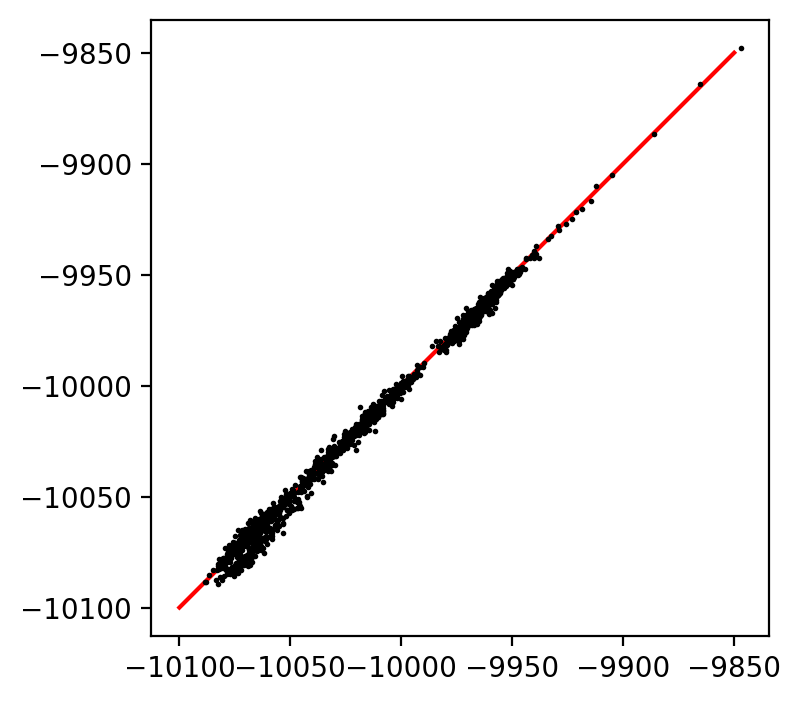

In [10]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (4,4)

plt.plot([-10100, -9850], [-10100, -9850], c='r', zorder=-1)
plt.scatter(local_energies.sum(axis=1), dft_energies, s=1, c='k')
plt.gca().set_aspect('equal');

# Train Only on DFT Energies


In [11]:
from src.data import numpy_dataset
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from src.nn import NeuralNetwork
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

class TrainOnSumsNetwork(NeuralNetwork):
    def _step(self, batch):
        x, y = batch
        y_hat = self.forward(x).sum(axis=1)
        loss = self.loss_fn(y_hat, y)
        return loss

dft_train_data = numpy_dataset(X.train, targets.train, batch_size=400, shuffle=True)
dft_val_data = numpy_dataset(X.val, targets.val, batch_size=400, shuffle=False)

layers = [X.train.shape[-1], 100, 100, 100, 1]
dft_trained_nn = TrainOnSumsNetwork(
    layers, activation="CELU", optimizer="Adam", optimizer_kwargs={"lr": 1e-3},
)

trainer = Trainer(
    accelerator="auto",
    max_epochs=2_000,
    log_every_n_steps=5,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=50, mode="min"),
        ModelCheckpoint(
            monitor="val_loss", filename="best", save_weights_only=True
        ),
    ],
    logger=[TensorBoardLogger("logs"), CSVLogger("logs")],
)
trainer.fit(dft_trained_nn, dft_train_data, dft_val_data)

checkpoint = trainer.checkpoint_callback.dirpath + '/best.ckpt'
dft_trained_nn = TrainOnSumsNetwork.load_from_checkpoint(checkpoint)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs
Missing logger folder: logs/lightning_logs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81.0 K
-------------------------------------
81.0 K    Trainable params
0         Non-trainable params
81.0 K    Total params
0.324     Total estimated model params size (MB)
/opt/miniconda3/envs/transfer-learning/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory logs/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Epoch 708: 100%|██████████| 5/5 [00:00<00:00, 25.62it/s, loss=1.39, v_num=0]  


## NN Model Performance


In [12]:
with torch.no_grad():
    y_pred_dft = X.map(torch.FloatTensor)\
                    .map(dft_trained_nn)\
                    .map(lambda x: x.sum(axis=1))

y_pred_dft.map(mae, targets)

(train=0.8923922617813416, val=3.016418780883663, test=2.735808222276419)

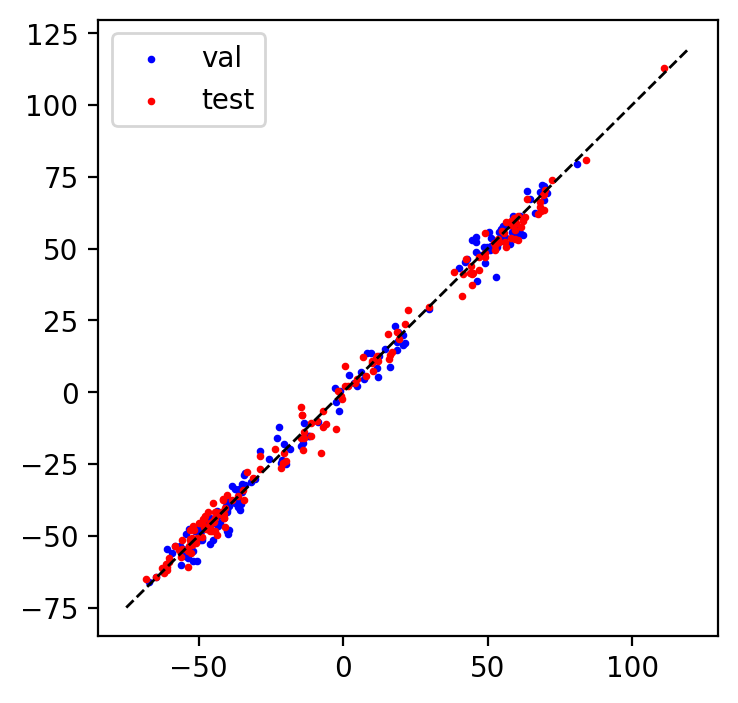

In [14]:
for split, c in zip(('val', 'test'), 'br'):
    plt.scatter(targets[split], y_pred_dft[split], c=c, label=split, s=3)

plt.plot([-75, 120], [-75, 120], c='k', linestyle='--', linewidth=1)
plt.legend();

## Correlation Between Learned and GAP17 Local Energies


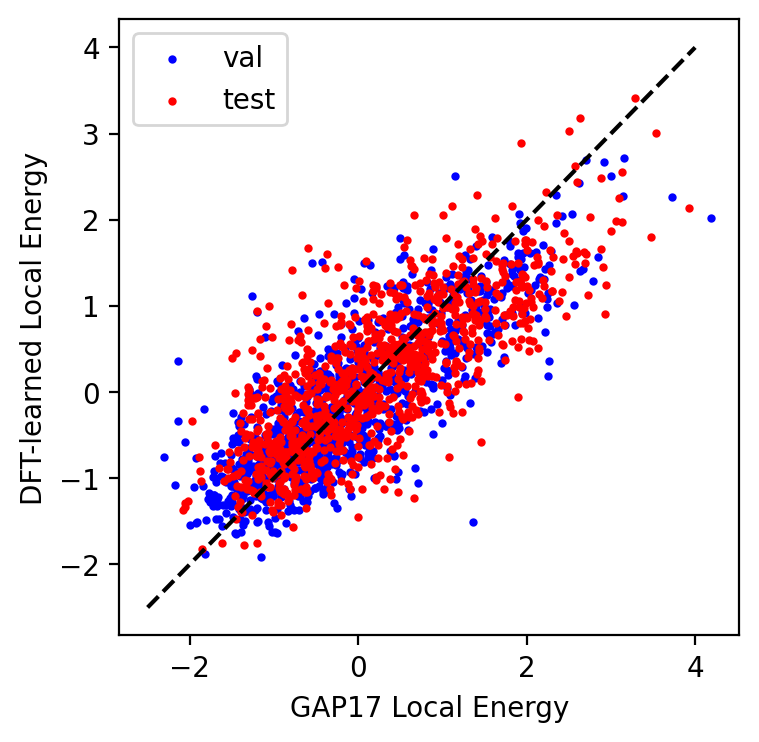

In [20]:
with torch.no_grad():
    dft_trained_local_energy_pred = X | torch.FloatTensor | dft_trained_nn

for split, c in zip(("val", "test"), "br"):
    plt.scatter(
        y[split].reshape(-1)[:1_000],
        dft_trained_local_energy_pred[split].reshape(-1)[:1_000],
        c=c,
        label=split,
        s=4,
    )

plt.xlabel("GAP17 Local Energy")
plt.ylabel("DFT-learned Local Energy")
plt.plot([-2.5, 4], [-2.5, 4], c="k", linestyle="--")
plt.legend();

# Pre-training


In [21]:
local_energy_train_data = numpy_dataset(
    X.train.reshape(-1, X.train.shape[-1]), 
    y.train.reshape(-1, 1), 
    batch_size=400, shuffle=True
)

local_energy_val_data = numpy_dataset(
    X.val.reshape(-1, X.val.shape[-1]), 
    y.val.reshape(-1, 1), 
    batch_size=400, shuffle=False
)

In [37]:
layers = [X.train.shape[-1], 100, 100, 100, 1]
pretrained_nn = NeuralNetwork(
    layers, activation="CELU", optimizer="Adam", optimizer_kwargs={"lr": 1e-3}
)

pre_trainer = Trainer(
    accelerator="auto",
    max_epochs=2_000,
    log_every_n_steps=5,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        ModelCheckpoint(
            monitor="val_loss", filename="best", save_weights_only=True
        ),
    ],
)
pre_trainer.fit(pretrained_nn, local_energy_train_data, local_energy_val_data)

pre_trained_checkpoint = pre_trainer.checkpoint_callback.dirpath + '/best.ckpt'
pretrained_nn = NeuralNetwork.load_from_checkpoint(pre_trained_checkpoint)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81.0 K
-------------------------------------
81.0 K    Trainable params
0         Non-trainable params
81.0 K    Total params
0.324     Total estimated model params size (MB)


Epoch 31: 100%|██████████| 234/234 [00:03<00:00, 73.97it/s, loss=0.00612, v_num=20]


## Pretraining Evaluation


In [38]:
with torch.no_grad():
    y_pretrained_pred = X | torch.FloatTensor | pretrained_nn

flat_pred = y_pretrained_pred | (lambda a: a.reshape(-1))
flat_y = y | (lambda a: a.reshape(-1))

# MAE for local energies (meV)
flat_pred.map(mae, flat_y)

(train=0.05431572262694773, val=0.06011101253651876, test=0.06126076888134106)

The pretrained model is very good at predicting GAP17 local energies.


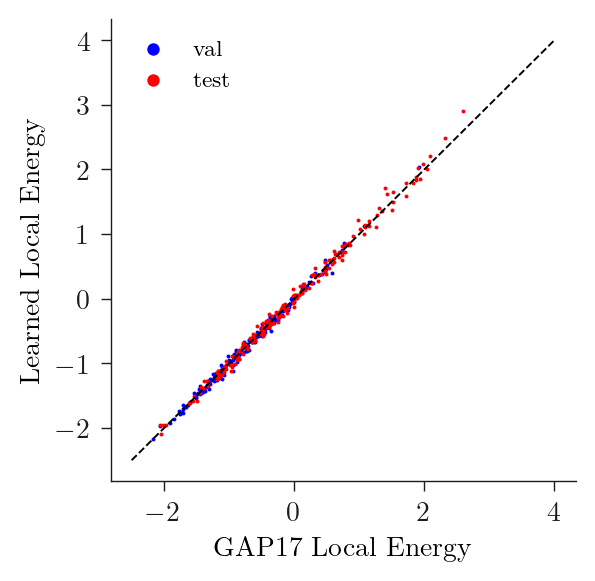

In [39]:
for split, c in zip(("val", "test"), "br"):
    scatter(flat_y[split], flat_pred[split], c=c, label=split, s=2, N=200)

plt.xlabel("GAP17 Local Energy")
plt.ylabel("Learned Local Energy")
plot([-2.5, 4], [-2.5, 4], c="k", linestyle="--")
legend()

This naturally leads to similar accuracies for structural energies as GAP (2.38 eV MAE)


In [40]:
local_energy_trained_dft_predictions = y_pretrained_pred | (lambda a: a.sum(axis=1))
local_energy_trained_dft_predictions.map(mae, targets)

(train=2.4434304367135087, val=2.82669523077986, test=2.4937872466387465)

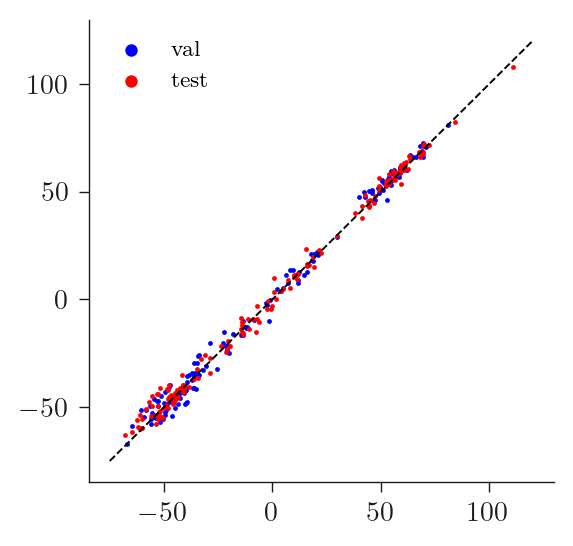

In [41]:
for split, c in zip(("val", "test"), "br"):
    scatter(
        targets[split],
        local_energy_trained_dft_predictions[split],
        c=c,
        label=split,
        s=3,
        N=500,
    )

plot([-75, 120], [-75, 120], c="k", linestyle="--")
legend()

# Finetuning


In [45]:
pre_trained_checkpoint = pre_trainer.checkpoint_callback.dirpath + '/best.ckpt'
finetuned_on_dft_nn = SummingNetwork.load_from_checkpoint(pre_trained_checkpoint, lr=1e-4)

trainer = Trainer(
    accelerator="auto",
    max_epochs=2_000,
    log_every_n_steps=5,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=100, mode="min"),
        ModelCheckpoint(
            monitor="val_loss", filename="best", save_weights_only=True
        ),
    ],
)
trainer.fit(finetuned_on_dft_nn, dft_train_data, dft_val_data)

checkpoint = trainer.checkpoint_callback.dirpath + '/best.ckpt'
finetuned_on_dft_nn = SummingNetwork.load_from_checkpoint(checkpoint)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81.0 K
-------------------------------------
81.0 K    Trainable params
0         Non-trainable params
81.0 K    Total params
0.324     Total estimated model params size (MB)


Epoch 285: 100%|██████████| 5/5 [00:00<00:00, 27.91it/s, loss=2.26, v_num=21]


In [46]:
with torch.no_grad():
    y_pred_fine_tuned_dft = X | torch.FloatTensor | finetuned_on_dft_nn

y_pred_fine_tuned_dft.map(mae, targets)

(train=1.1055250068011326, val=2.1781931751569754, test=2.057608477398624)